In [17]:

import numpy as np

from collections import defaultdict
import copy

import sys
import os
import time
import datetime
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn



In [18]:
import sys
sys.path.append('/home/amanda/demo/poison/ASPARaGUS')

In [19]:
from forest.victims.models import get_model
from forest.victims.models import resnet_picker
#from forest.victims.training import get_optimizers
#from forest.hyperparameters import training_strategy

#from ..utils import set_random_seed
#from ..consts import BENCHMARK
#torch.backe.nds.cudnn.benchmark = BENCHMARK

#from .victim_base import _VictimBase

In [20]:
#model = resnet_picker('ResNet18', 'CIFAR10')
#model.load_state_dict(torch.load("/home/nbuser/demo/poison/models/clean_model/full_epoch_30.pth"))
model = get_model('ResNet18', 'CIFAR10', load_model="/home/amanda/demo/poison/models/clean_model/full_epoch_30.pth")
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [21]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [24]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
X_train = np.array(trainset.data)
y_train = np.array(trainset.targets)
X_test = np.array(testset.data)
y_test = np.array(testset.targets)

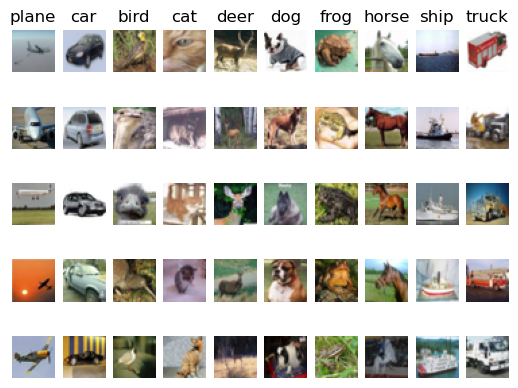

In [26]:
num_classes = len(classes)
samples_per_class = 5
for y, label in enumerate(classes):
    in_class_ids = np.flatnonzero(y_train == y)
    in_class_ids = np.random.choice(in_class_ids, samples_per_class, replace=False)
    for i, idx in enumerate(in_class_ids):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(label)
plt.show()

In [27]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000125)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [29]:

dataloader = testloader
correct_number = 0
for data, targets in dataloader: 
    data = data.to(device)
    targets = targets.to(device)
#    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        outputs = model(data)
        loss = criterion(outputs, targets)
        _, preds = torch.max(outputs, 1)
                    
    loss += loss.item() * data.size(0)
    correct_number += torch.sum(preds == targets.data)

epoch_loss = loss / len(dataloader.dataset)
epoch_accuracy = correct_number.double() / len(dataloader.dataset)
print('loss = {:.4f} accuracy = {:.4f}'.format(epoch_loss, epoch_accuracy))


loss = 0.0000 accuracy = 0.8533


In [30]:
outputs

tensor([[-2.0324, -6.6881,  1.2225,  8.1845,  1.8133,  1.8411,  2.8771, -2.3605,
         -2.0702, -2.7667],
        [-0.6140, -3.8281,  0.6158,  0.9700, -0.4090,  8.3777, -1.0560, -2.1912,
         -1.6268, -0.2732],
        [ 1.0834, 10.4218,  1.2280, -2.7546, -1.5866, -4.5150, -0.4169, -4.6553,
          0.5081,  0.6844],
        [ 0.1652, -1.7873, -1.4605, -1.6348,  0.4670, -2.6172, -2.9212,  9.3078,
         -0.0874,  0.5698]], device='cuda:0')

In [31]:
num_epochs=5
dataloader = trainloader
for epoch in range(num_epochs):
    print('epoch = {}'.format(epoch))
    loss = 0.0
    correct_number = 0

    for data, targets in dataloader: 
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(data)
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
                    
        loss += loss.item() * data.size(0)
        correct_number += torch.sum(preds == targets.data)
        
    epoch_loss = loss / len(dataloader.dataset)
    epoch_accuracy = correct_number.double() / len(dataloader.dataset)
    print('loss = {:.4f} accuracy = {:.4f}'.format(epoch_loss, epoch_accuracy))


epoch = 0
loss = 0.0002 accuracy = 0.6848
epoch = 1
loss = 0.0001 accuracy = 0.8269
epoch = 2
loss = 0.0000 accuracy = 0.8648
epoch = 3
loss = 0.0000 accuracy = 0.8848
epoch = 4
loss = 0.0000 accuracy = 0.9018
